---
title: "DDIM Tutorial"
author: "Andreas Makris"
date: 2024-12-20
categories: [diffusion, tutorial]
description: "A tutorial to understand how to sample faster using DDPM and DDIM."
---


![](ddim_img.jpeg)

The main downside of diffusion models is the time they take to generate samples. To do so, they need to reverse all forward timesteps (which are often 1,000 or more). There are a few ways we can speed this up, while only slightly compromising sample quality.

# Skipping DDPM Timesteps

The simplest way to speed the reverse process is to skip some of the timesteps.

Let $\bar{\alpha}_1,...,\bar{\alpha}_T$ be the diffusion parameters with $\bar{\alpha}_1\approx 1.0$ and $\bar{\alpha}_T\approx 0.0$. Then, we select $\tau < T$ of these parameters $\bar{\alpha}_{i_i},...,\bar{\alpha}_{i_\tau}$ , where $i_1=1<i_2<...<i_\tau=T$ and skip the rest. There are many ways to choose the individual indices $i_2,...,i_{\tau-1}$. The simplest choice is to choose evenly spaced indices (or almost evenly spaced indices), i.e. use numpy's linspace function, with the option to only return integers. 

To give a concrete example, consider $T=1,000$ and $\tau=100$. Then, we select $\alpha_1,\alpha_{11},...,\alpha_{989}, \alpha_{1000}$.

After selecting $\bar{\alpha}$, we need to **derive** $\beta$. This step is crucial because, in the original formulation of DDPM, we began by defining $\beta$ and then derived $\bar{\alpha}$. For the diffusion process to function effectively, it is essential that $\bar{\alpha}_1 \approx 1.0$ and $\bar{\alpha}_T \approx 0.0$. This ensures that:

$$p_T(\boldsymbol{x}_T)\approx \mathcal{N}(0,I)$$

and 

$$p_t(\boldsymbol{x}_t)\approx p_{\text{data}} \quad \text{for small } t$$

To derive the $\beta$ we look back at how we created $\bar{\alpha}$ from them and reverse that. Below we show the first 2 $\beta$ and the general case:

$\bar{\alpha}_1$ = $(1 - \beta_1)$

$\bar{\alpha}_2$ = $\bar{\alpha}_1(1 - \beta_2)$

$\bar{\alpha}_t$ = $\bar{\alpha}_{t-1}(1 - \beta_t)$

and so on. We can solve this with respect to $\beta$:

$\beta_1 = 1 - \bar{\alpha}_1$

$\beta_2 = 1 - \frac{\bar{\alpha}_2}{\bar{\alpha}_1}$

$\beta_t = 1 - \frac{\bar{\alpha}_{t}}{\bar{\alpha}_{t-1}}$

In our case, since we only pick some of the $\bar{\alpha}$, want them to preserve this property. Let $\tilde{\beta}$ be the new $\beta$ corresponding to the re-indexed $\bar{\alpha}$. Then we want:

$\bar{\alpha}_{i_1}$ = $(1 - \tilde{\beta}_{1})$

$\bar{\alpha}_{i_2}$ = $\bar{\alpha}_{i_1}(1 - \beta_2)$

$\bar{\alpha}_{i_t}$ = $\bar{\alpha}_{i_{t-1}}(1 - \beta_t)$

and again if we solve with respect to $\tilde{\beta}$:

$\tilde{\beta}_1 = 1 - \bar{\alpha}_{i_1}$

$\tilde{\beta}_2 = 1 - \frac{\bar{\alpha}_{i_2}}{\bar{\alpha}_{i_1}}$

$\tilde{\beta}_t = 1 - \frac{\bar{\alpha}_{i_t}}{\bar{\alpha}_{i_{t-1}}}$

Below we show how to code this up.

In [3]:
import numpy as np

# Create the beta
beta_start = 0.0001
beta_end = 0.02
num_timesteps = 1000

betas = np.linspace(beta_start, beta_end, num_timesteps)

# Create the alpha_bars
alpha_bar = np.cumprod(1 - betas)
# Check the values of the first and last alpha_bar
print(f"The first alpha_bar is close to 1: {alpha_bar[0]:.5f}")
print(f"The last alpha_bar is close to 0: {alpha_bar[-1]:.5f}")

# Choose some of the alpha_bar (e.g. 10)
respaced_indices = np.linspace(0, 999, 10, dtype=np.int16) # We use 0-999 due to Python indexing
respaced_alpha_bar = alpha_bar[respaced_indices]

# Derive the beta from the alpha
alpha_prev = 1.0
beta_tilde = np.zeros(10)
for t in range(10):
    current_alpha = respaced_alpha_bar[t]
    beta_tilde[t] = 1 - current_alpha / alpha_prev
    alpha_prev = current_alpha

# Derive the alpha from beta tilde to make sure they are correct!
check_respaced_alpha_bar = np.cumprod(1 - beta_tilde)
print(f"\nThe respaced alphas are the same: {np.all((check_respaced_alpha_bar - respaced_alpha_bar)<0.00001)}")


The first alpha_bar is close to 1: 0.99990
The last alpha_bar is close to 0: 0.00004

The respaced alphas are the same: True


To check how well sample quality is with 10 respaced reverse steps, rather than 1000 we modify the exact DDPM to sample.

Estimated mean is 4.992445945739746
Estimated std is 1.7646558284759521


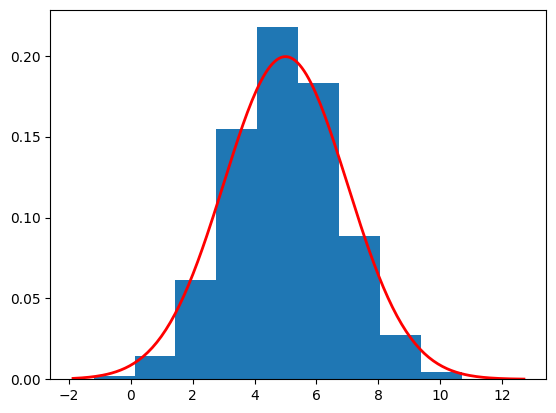

In [5]:
import torch

import numpy as np
import matplotlib.pyplot as plt
    
class Exact_DDPM():
    def __init__(self, num_timesteps, betas):
        super(Exact_DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.beta = torch.from_numpy(betas)  
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha,dim=0)

        self.sqrt_beta = torch.sqrt(self.beta)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_alpha_bar = torch.sqrt(1-self.alpha_bar)
        self.reverse_factor = 1 / torch.sqrt(1-self.beta)
        self.reverse_factor_2 = torch.sqrt(1-self.alpha_bar)
    
    def reverse_diff(self, sample_size):
        with torch.inference_mode():
            samples = torch.zeros((self.num_timesteps+1, sample_size))
            samples[-1] = torch.randn(sample_size)
            for t in range(self.num_timesteps-1,-1,-1):
                exact_sample = self.reverse_factor[t] * (samples[t+1] + self.beta[t]  * self.score(samples[t+1], t+1))
                if t != 0:
                    samples[t] = exact_sample + self.sqrt_beta[t] * torch.randn(sample_size)
                else:
                    samples[t] = exact_sample
            return samples
    
    def score(self,x,t):
        numerator = 5 *self.sqrt_alpha_bar[t-1] - x
        denomenator = 3 * self.alpha_bar[t-1] + 1
        return numerator / denomenator    
    

# Use the beta_tilde from above
diffusion = Exact_DDPM(10, beta_tilde)

samples = diffusion.reverse_diff(10000).numpy()
plot_sample = samples[0]
print(f"Estimated mean is {np.mean(plot_sample)}")
print(f"Estimated std is {np.std(plot_sample)}")
plt.hist(plot_sample, density=True)

# Define parameters for the normal distribution
mean = 5.0
std = 2.0

# Create a range of x values
xmin, xmax = plt.xlim()
x = torch.linspace(xmin, xmax, 200).numpy()

# Compute the normal PDF: (1/(σ√(2π))) exp(-(x-μ)²/(2σ²))
pdf = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mean)/std)**2)

# Plot the PDF line
plt.plot(x, pdf, 'r', linewidth=2)

plt.show()

We observe that the estimation of the mean and standard deviation is slightly worse compared to the 1,000-timestep reverse process (with an estimated mean of 4.998 and an estimated standard deviation of 1.995). This minor difference occurs because the distribution we are estimating is very simple. However, if we attempt the same approach with more complex target distributions, such as images, the decline in sample estimation would be significantly greater.

Remarkably, there exists a different method to transform noise into data **without the need to modify the neural network** (or the exact score in our toy example). This is particularly impressive because it allows us to enhance performance without retraining or altering the existing model architecture. This method sometimes achieves a smaller decline in performance when using fewer reverse timesteps. This brings us to the DDIM, a generalisation to the DDPM.

# DDIM

We are not going to go over the detailed derivations of the [DDIM](https://arxiv.org/abs/2010.02502) reverse process, but we explain the general idea. In the [DDPM](https://arxiv.org/abs/2006.11239) case we first define $p(\boldsymbol{x}_t|\boldsymbol{x}_{t-1})$ assuming the Markov Property and from that we derive $p(\boldsymbol{x}_t|\boldsymbol{x}_{0})$ and $p(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_{0})$. On the other hand, in the case of the DDIM, we define $p(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_{0})$, assuming a different non-Markovian structure and then derive $p(\boldsymbol{x}_t|\boldsymbol{x}_{0})$ and $p(\boldsymbol{x}_t|\boldsymbol{x}_{t-1})$. To do so, we give a specific form to $p(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_{0})$, so that $p(\boldsymbol{x}_t|\boldsymbol{x}_{0})$ that is induced from it has the same form as in the DDPM case (so that we can use the same neural network). The form that is required to achieve this is the following:

$$p(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_{0})=\mathcal{N}(\sqrt{\bar{\alpha}_{t-1}}\boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_{t-1}-\sigma_t^2}\frac{\boldsymbol{x}_t-\sqrt{\bar{\alpha}_{t}}\boldsymbol{x}_0}{\sqrt{1-\bar{\alpha}_t}},\sigma_t^2 I)$$

where $\sigma_t^2$ is a user defined hyperparameter. If we choose $\sigma_t^2=\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}}\beta_t$ we have the DDPM model! This leads to the hyperparameter $\eta$ that is used to choose $\sigma_t:=\eta\sqrt{\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}}\beta_t}$. If we set $\eta=1$ we have the DDPM reverse process. If we set $\eta=0$ we have a deterministic model! The [DDIM](https://arxiv.org/abs/2010.02502) paper experimented with this hyperparameter and showed that the quality degradation was significantly mitigated when DDIM was used with $\eta=0$! Below we code up the DDIM reverse process and compare it to the DDPM with 10 reverse steps. Before doing so we go over some details of the DDPM sampling process that also appear in the DDIM sampling process.

## DDPM Sampling Explained

DDPM sampling starts with some isotropic noise and iteratively uses the following formula:

$$\boldsymbol{x}_{t-1}=\frac{1}{\sqrt{\alpha}_t}\left(\boldsymbol{x}_{t}-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\hat{\epsilon}(\boldsymbol{x}_{t},t)\right)+\sqrt{\beta}_t \boldsymbol{z}_t,$$

where $\hat{\epsilon}(\boldsymbol{x}_{t},t)$ is the neural network that estimates the noise $\left(\text{note that in our code we instead use }\nabla_{\boldsymbol{x}_t}\log p_t(\boldsymbol{x}_t)=-\frac{\hat{\epsilon}(\boldsymbol{x}_{t},t)}{\sqrt{1-\bar{\alpha}_t}}\right)$ and $\boldsymbol{z}_t\sim\mathcal{N}(0,I)$.

The DDPM sampling formula actually comes from the combination of two other formulas. First we solve the forward diffusion equations with respect to $\boldsymbol{x}_0$ to obtain an approximation of $\boldsymbol{x}_0$ given $\boldsymbol{x}_t$:

$$\hat{\boldsymbol{x}}_0(\boldsymbol{x}_t)=\frac{1}{\sqrt{\bar{\alpha}_t}}\left(\boldsymbol{x}_t-\sqrt{1-\bar{\alpha}_t}\hat{\epsilon}(\boldsymbol{x}_{t},t)\right)$$

Then, we use this approximation to estimate the mean of $p(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_{0})$:

$$\boldsymbol{m}_t(\boldsymbol{x}_t,\hat{\boldsymbol{x}}_0 )=\frac{(1-\bar{\alpha}_{t-1})\sqrt{\alpha}_t\boldsymbol{x}_t+\sqrt{\bar{\alpha}_{t-1}}\beta_t \hat{\boldsymbol{x}}_0}{1-\bar{\alpha}_t}$$

Finally we add some noise $(\sqrt{\beta}_t \boldsymbol{z}_t)$.

This means that what the reverse diffusion actually does is it **estimates** $\boldsymbol{x}_0$ **at each timestep** and then uses that to create $\boldsymbol{x}_{t-1}$. 

For the DDIM we do a similar thing. We first estimate $\boldsymbol{x}_0$ and then use is to sample from  $p(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\hat{\boldsymbol{x}}_{0})$.

Estimated mean is 4.973484516143799
Estimated std is 1.6710020303726196


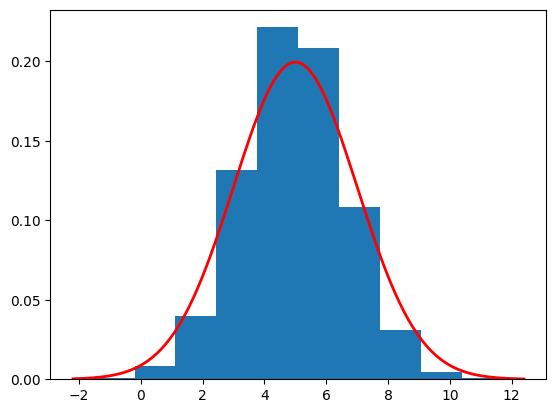

In [23]:
import torch

import numpy as np
import matplotlib.pyplot as plt
    
class Exact_DDIM():
    def __init__(self, num_timesteps, betas):
        super(Exact_DDIM, self).__init__()
        self.num_timesteps = num_timesteps
        self.beta = torch.from_numpy(betas)  
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha,dim=0)

        # Create a tensor of alpha_bar_{t-1} so be multiplied to create the sigmas
        self.alpha_bar_prev = torch.cat([torch.tensor(torch.nan).unsqueeze(0),self.alpha_bar[:-1]])

        self.sqrt_beta = torch.sqrt(self.beta)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_alpha_bar = torch.sqrt(1-self.alpha_bar)
        self.reverse_factor = 1 / torch.sqrt(1-self.beta)
        self.reverse_factor_2 = torch.sqrt(1-self.alpha_bar)

    
    def reverse_diff(self, sample_size, eta=0.0):
        # First calculate sigma through eta
        # Note that sigma[0] is none. We do not use sigma[0] 
        # since we are estimating x0 using x1
        sigma = eta * torch.sqrt((1 - self.alpha_bar_prev)/(1 - self.alpha_bar)*self.beta)
        sigma2 = sigma ** 2

        with torch.inference_mode():
            samples = torch.zeros((self.num_timesteps+1, sample_size))
            samples[-1] = torch.randn(sample_size)
            for t in range(self.num_timesteps-1,-1,-1):
                xt = samples[t+1] # this is x_{t+1}, we estimate x_t
                x0 = (xt + (1 - self.alpha_bar[t]) *  self.score(xt, t+1)) / self.sqrt_alpha_bar[t]
                if t > 0:
                    mean = (self.sqrt_alpha_bar[t-1] * x0 +
                            torch.sqrt(1 - self.alpha_bar[t-1]- sigma2[t]) *
                            (xt - self.sqrt_alpha_bar[t] * x0) / torch.sqrt(1-self.alpha_bar[t])
                            )
                    # Add noise
                    samples[t] = mean + sigma[t] * torch.randn_like(mean)
                else:
                    samples[0] = x0

            return samples
    
    def score(self,x,t):
        numerator = 5 *self.sqrt_alpha_bar[t-1] - x
        denomenator = 3 * self.alpha_bar[t-1] + 1
        return numerator / denomenator    
    

# Use the beta_tilde from above
diffusion = Exact_DDIM(10, beta_tilde)

samples = diffusion.reverse_diff(10000).numpy()
plot_sample = samples[0]
print(f"Estimated mean is {np.mean(plot_sample)}")
print(f"Estimated std is {np.std(plot_sample)}")
plt.hist(plot_sample, density=True)

# Define parameters for the normal distribution
mean = 5.0
std = 2.0

# Create a range of x values
xmin, xmax = plt.xlim()
x = torch.linspace(xmin, xmax, 200).numpy()

# Compute the normal PDF: (1/(σ√(2π))) exp(-(x-μ)²/(2σ²))
pdf = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mean)/std)**2)

# Plot the PDF line
plt.plot(x, pdf, 'r', linewidth=2)

plt.show()

We see slightly worse results for the estimated mean and std. It is important to check both methods when attempting sampling to see which one performs better for your specific task.